# Exercise Sheet 11 - MLP
Yiping Deng, Shalom-David Anifowoshe

In [36]:
# initialize numpy enviroment
%matplotlib notebook
import numpy as np
from numpy import square
import matplotlib.pyplot as plt

In [2]:
# Code for visualizing MLP structure

def draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    '''
    Draw a neural network cartoon using matplotilb.
    
    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])
    
    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

## Structure of the Multiple Layer Perceptron
We use the classic structure of Multiple Layer Perceptron, with

1. Input Layer: 2 input neurons and 1 bias unit
2. One Hidden Layer: 2 hidden neurons with 1 bias Unit
3. Output Layer: 1 output neurons

### Bias unit
Bias unit guarantees that it is a affine combination of previous layer inside of the neuron, increasing the model flexibility of each neurons.


The following is the visualization of the MLP ( note that bias unit is emitted)

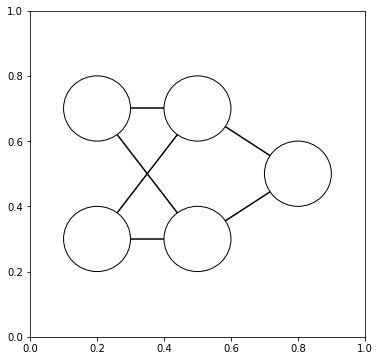

In [3]:
mlp_fig = plt.figure(figsize=(6, 6))
draw_neural_net(mlp_fig.gca(), .2, .8, .1, .9, [2, 2, 1])

## Implementation of the MLP
Firstly, let's define the necessary activation function $\sigma$ and the quadratic loss function

In [4]:
def sigmoid(x):
    """Sigmoid Function
    Input: A vector in any dimension
    Output: Applying Sigmoid function elementwise
    """
    exp_part = np.exp(-x)
    return 1 / (1 + exp_part)

def sigmoid_grad(x):
    """Gradient of the sigmoid function
    Input: A vector in any dimension
    Output: Calculate Gradient of Sigmoid function elementwise
    """
    sig = sigmoid(x)
    return np.multiply(sig, 1 - sig)

def loss(y_pred, y):
    diff = y_pred - y
    np.sum(np.square(diff))
    

    
def mean_square_error(y_pred, y):
    m, n = y_pred.shape
    l = loss(y_pred, y)
    return l / m / n

The Gradient of the Sigmoid function is calculated using the following formula:
$$ \sigma'(x) = \sigma(x) \cdot (1 - \sigma(x)) $$

Given two weight matrix $W_1, W_2$, representing the weight from the input layer to the hidden layer and from the hiddden layer to the output layer, including the bias term, we can conclude that $W_1 \in \mathbb{R}^{2 \times 3}$ and $W_2 \in \mathbb{R}^{1 \times 3}$.

## Forward Propagation
Our Entire Neural Network can be represent as a single function:
$$ N: \mathbb{R}^2 \to \mathbb{R} $$
Such function will:
1. Assiciate the input $X \in \mathbb{R}^2$ with a bias term, forming $X_{biased}$
2. Calculate the offine combination
$$ z_2 = W_1 \cdot X_{biased} $$, where $z_2 \in \mathbb{R}^2$
3. Apply the Sigmoid function, obtaining the value of the neurons
$$ a_2 = \sigma(z_2) $$, where $a_2 \in \mathbb{R}^2$
4. Assiciate $a_2$ with a bias term
5. Calculate the affine combination and return
$$ z_3 = W_2 \cdot a_2 $$, where $z_3 \in \mathbb{R}$
6. Calculate $a_3 = \sigma(z_3)$. Note that in the lecture note, we do not apply sigmoid function for the last layer.
However, we applied sigmoid here because we want the result to be in the inteval $[0,1]$ instead of $\mathbb{R}$

In [5]:
def neural_net(X, W1, W2):
    """Implementation of the MLP
    Input: takes input data X in 2 dimension, 2 weight matrix
    """
    # bias term
    X_b = np.ones((3,1))
    X_b[1:] = X
    a_1 = X_b
    
    # calculate z_2
    z_2 = np.matmul(W1, a_1)
    
    # calculate a_2
    a_2 = sigmoid(z_2)
    
    # associate with bias
    b_2 = np.ones((3, 1))
    b_2[1:] = a_2
    a_2 = b_2
    
    # calculate z_3
    z_3 = np.matmul(W2, a_2)
    
    # calculate a_3
    a_3 = sigmoid(z_3)
    
    return a_3[0][0]

## Calculate the gradient with respect to $W_1$ and $W_2$ using Backpropagation

We are using backpropagation to train $W^{(1)}$ and $W^{(2)}$

First, perform a full forward propagation of the neural network to obtain
$a_1, a_2, a_3, z_2, z_3$

Second, calculate
$$ \delta^{(3)} = a_k^{(3)} - y_k $$
$$ \delta^{(2)} = W_2' \delta^{(3)}.*\sigma'(z^{(2)}) $$

Finally, calculate the gradient at layer $l$ using
\begin{equation}
\frac{\partial}{\partial W_{ij}^{(l)}} = \delta^{(l + 1)} \cdot (a^{(l)})'
\end{equation}

In [6]:
def neural_net_train(X, W1, W2, Y):
    """Implementation of the MLP
    Input: takes input data X in 2 dimension, 2 weight matrix, y
    Output: 
    """
    # bias term
    X_b = np.ones((3,1))
    X_b[1:] = X
    a_1 = X_b
    
    # calculate z_2
    z_2 = np.matmul(W1, a_1)
    
    # calculate a_2
    a_2 = sigmoid(z_2)
    
    # associate with bias
    b_2 = np.ones((3, 1))
    b_2[1:] = a_2
    a_2 = b_2
    
    # calculate z_3
    z_3 = np.matmul(W2, a_2)
    
    a_3 = sigmoid(z_3)
    # forward propagation end
    # -----------------------
    
    # start of backpropagation
    
    # delta 3 in  1 x 1
    delta_3 = a_3 - Y 
    
    # delta 2 in 2 x 1
    delta_2 = np.multiply(np.matmul(W2.T, delta_3)[1:], sigmoid_grad(z_2))
    
    # we don't have delta 1
    grad_w_1 = np.matmul(delta_2, a_1.T)
    
    grad_w_2 = np.matmul(delta_3, a_2.T)
    # grad_w_2 = np.matmul(delta_3.T, a_2)
    
    return a_3, grad_w_1, grad_w_2# grad_w_2

## Dealing with Multiple training data at the same time
The gradient formula is averaged. Namely
$$\frac{\partial}{\partial W_{ij}^{(l)}} = \frac{1}{m} \sum_{i = 1}^{m} \delta_{(i)}^{(l + 1)} \cdot (a_{(i)}^{(l)})' $$

In [7]:
# accumulate the gradient result
def batch_neural_net_train(X, W1, W2, Y):
    # X contains m training examples as row vectors
    # X is   m x 3
    m, _ = X.shape
    
    grad_w_1_acc = np.zeros((2,3))
    grad_w_2_acc = np.zeros((1,3))
    pred_all = np.zeros((m, 1))
    for i in range(m):
        pred, grad_w_1, grad_w_2 = neural_net_train(np.asmatrix(X[i]).T, W1, W2, np.asmatrix(Y[i]))
        grad_w_1_acc = grad_w_1_acc - grad_w_1
        grad_w_2_acc = grad_w_2_acc - grad_w_2
        pred_all[i] = pred[0][0]
    error = np.sum(np.square(pred_all - Y)) / m
    return pred_all, grad_w_1_acc / m, grad_w_2_acc / m, error

## Gradient Decent
We optimize our weight using gradient decent.
We update the weight using the following formula:
$$ W_{ij}^{(l)} = W_{ij}^{(l)} - \alpha * \frac{\partial}{\partial W_{ij}^{(l)}} $$

In [8]:
def train(X, Y, step = 2000, alpha = 4.0):
    # initiate w_1, w_2
    w_1 = np.random.randn(2,3)
    w_2 = np.random.randn(1, 3)
    
    # train
    for i in range(step):
        pred, grad_w_1, grad_w_2, err = batch_neural_net_train(X, w_1, w_2, Y)
        w_1_new = w_1 + alpha * grad_w_1
        w_2_new = w_2 + alpha * grad_w_2
        w_1 = w_1_new
        w_2 = w_2_new
        print('step: {} - error: {}'.format(i, err))
    return w_1, w_2

We explicitly print the training error, and after the experiment, we find the optimal $\alpha = 4.0$ and $step = 2000$

In [9]:
# build up a training data
X = np.asmatrix([[1,1], [1,0], [0,1], [0, 0]])
Y = np.asmatrix([[0], [1], [1], [0]])

# train the neural network
w_1, w_2 = train(X, Y)

step: 0 - error: 0.3633636945095289
step: 1 - error: 0.26172880815262456
step: 2 - error: 0.2533828480173811
step: 3 - error: 0.25070177852172537
step: 4 - error: 0.24988666935103154
step: 5 - error: 0.24955784725618854
step: 6 - error: 0.24936947115359331
step: 7 - error: 0.24921940356510075
step: 8 - error: 0.24907749784066913
step: 9 - error: 0.24893517119266312
step: 10 - error: 0.24878919721553783
step: 11 - error: 0.24863798039983362
step: 12 - error: 0.24848032041076992
step: 13 - error: 0.24831508493579235
step: 14 - error: 0.24814112695391935
step: 15 - error: 0.24795725050084227
step: 16 - error: 0.24776218569291875
step: 17 - error: 0.24755458388266258
step: 18 - error: 0.24733299467786257
step: 19 - error: 0.24709585865590541
step: 20 - error: 0.24684148681830692
step: 21 - error: 0.24656804790784131
step: 22 - error: 0.24627354883368394
step: 23 - error: 0.24595581789953314
step: 24 - error: 0.2456124847922973
step: 25 - error: 0.24524096132578066
step: 26 - error: 0.24483

step: 301 - error: 0.00017379427349820703
step: 302 - error: 0.00017195123758387187
step: 303 - error: 0.0001701369206992434
step: 304 - error: 0.00016835073529710836
step: 305 - error: 0.0001665921086656242
step: 306 - error: 0.00016486048248378032
step: 307 - error: 0.0001631553123922332
step: 308 - error: 0.00016147606757893477
step: 309 - error: 0.00015982223037895292
step: 310 - error: 0.00015819329588796625
step: 311 - error: 0.0001565887715888764
step: 312 - error: 0.00015500817699102794
step: 313 - error: 0.00015345104328160682
step: 314 - error: 0.00015191691298866832
step: 315 - error: 0.00015040533965543146
step: 316 - error: 0.00014891588752537075
step: 317 - error: 0.00014744813123770967
step: 318 - error: 0.00014600165553293288
step: 319 - error: 0.00014457605496793596
step: 320 - error: 0.00014317093364046035
step: 321 - error: 0.00014178590492246225
step: 322 - error: 0.00014042059120210148
step: 323 - error: 0.00013907462363402841
step: 324 - error: 0.00013774764189764

step: 521 - error: 3.602619241145831e-05
step: 522 - error: 3.5846413809340806e-05
step: 523 - error: 3.566796492419382e-05
step: 524 - error: 3.5490832755531125e-05
step: 525 - error: 3.531500446064671e-05
step: 526 - error: 3.5140467352327606e-05
step: 527 - error: 3.4967208896611705e-05
step: 528 - error: 3.4795216710573e-05
step: 529 - error: 3.462447856015954e-05
step: 530 - error: 3.445498235804967e-05
step: 531 - error: 3.428671616155922e-05
step: 532 - error: 3.411966817057099e-05
step: 533 - error: 3.3953826725510246e-05
step: 534 - error: 3.378918030534178e-05
step: 535 - error: 3.362571752561046e-05
step: 536 - error: 3.346342713650912e-05
step: 537 - error: 3.330229802097692e-05
step: 538 - error: 3.3142319192828516e-05
step: 539 - error: 3.2983479794922765e-05
step: 540 - error: 3.282576909734844e-05
step: 541 - error: 3.266917649564608e-05
step: 542 - error: 3.251369150906044e-05
step: 543 - error: 3.235930377881632e-05
step: 544 - error: 3.220600306642576e-05
step: 545 -

step: 734 - error: 1.5256946254698491e-05
step: 735 - error: 1.5206798456125268e-05
step: 736 - error: 1.5156895689152432e-05
step: 737 - error: 1.5107236367599895e-05
step: 738 - error: 1.5057818918056373e-05
step: 739 - error: 1.5008641779757682e-05
step: 740 - error: 1.4959703404466377e-05
step: 741 - error: 1.4911002256350136e-05
step: 742 - error: 1.4862536811861785e-05
step: 743 - error: 1.4814305559626059e-05
step: 744 - error: 1.476630700031957e-05
step: 745 - error: 1.4718539646557863e-05
step: 746 - error: 1.4671002022779688e-05
step: 747 - error: 1.4623692665139247e-05
step: 748 - error: 1.4576610121387956e-05
step: 749 - error: 1.4529752950773192e-05
step: 750 - error: 1.4483119723921244e-05
step: 751 - error: 1.4436709022736571e-05
step: 752 - error: 1.4390519440290637e-05
step: 753 - error: 1.4344549580720053e-05
step: 754 - error: 1.4298798059121555e-05
step: 755 - error: 1.4253263501448702e-05
step: 756 - error: 1.4207944544409307e-05
step: 757 - error: 1.41628398353679

step: 959 - error: 8.105528600126477e-06
step: 960 - error: 8.085972624882076e-06
step: 961 - error: 8.066486905090181e-06
step: 962 - error: 8.047071105953922e-06
step: 963 - error: 8.027724894662833e-06
step: 964 - error: 8.00844794037755e-06
step: 965 - error: 7.98923991421836e-06
step: 966 - error: 7.970100489248675e-06
step: 967 - error: 7.95102934046298e-06
step: 968 - error: 7.932026144773195e-06
step: 969 - error: 7.913090580993693e-06
step: 970 - error: 7.894222329829854e-06
step: 971 - error: 7.87542107386298e-06
step: 972 - error: 7.856686497538844e-06
step: 973 - error: 7.838018287152278e-06
step: 974 - error: 7.819416130836569e-06
step: 975 - error: 7.8008797185501e-06
step: 976 - error: 7.782408742061347e-06
step: 977 - error: 7.76400289493973e-06
step: 978 - error: 7.745661872540205e-06
step: 979 - error: 7.727385371992271e-06
step: 980 - error: 7.709173092187056e-06
step: 981 - error: 7.691024733765798e-06
step: 982 - error: 7.672939999105613e-06
step: 983 - error: 7.65

step: 1361 - error: 3.662856182545297e-06
step: 1362 - error: 3.6568728886872516e-06
step: 1363 - error: 3.6509041715042845e-06
step: 1364 - error: 3.644949983833696e-06
step: 1365 - error: 3.6390102787034643e-06
step: 1366 - error: 3.6330850093302964e-06
step: 1367 - error: 3.627174129120336e-06
step: 1368 - error: 3.621277591665364e-06
step: 1369 - error: 3.6153953507450443e-06
step: 1370 - error: 3.6095273603243845e-06
step: 1371 - error: 3.6036735745527254e-06
step: 1372 - error: 3.597833947764045e-06
step: 1373 - error: 3.5920084344739496e-06
step: 1374 - error: 3.5861969893817404e-06
step: 1375 - error: 3.5803995673665614e-06
step: 1376 - error: 3.574616123488606e-06
step: 1377 - error: 3.5688466129876766e-06
step: 1378 - error: 3.563090991281496e-06
step: 1379 - error: 3.5573492139662515e-06
step: 1380 - error: 3.551621236814703e-06
step: 1381 - error: 3.545907015775668e-06
step: 1382 - error: 3.5402065069732892e-06
step: 1383 - error: 3.5345196667060797e-06
step: 1384 - error: 

step: 1585 - error: 2.6154976056654264e-06
step: 1586 - error: 2.611878044393121e-06
step: 1587 - error: 2.608265957848746e-06
step: 1588 - error: 2.604661325523719e-06
step: 1589 - error: 2.6010641269799397e-06
step: 1590 - error: 2.5974743418492497e-06
step: 1591 - error: 2.593891949832227e-06
step: 1592 - error: 2.5903169307003063e-06
step: 1593 - error: 2.586749264291853e-06
step: 1594 - error: 2.5831889305160074e-06
step: 1595 - error: 2.5796359093489534e-06
step: 1596 - error: 2.576090180835491e-06
step: 1597 - error: 2.5725517250886507e-06
step: 1598 - error: 2.5690205222883427e-06
step: 1599 - error: 2.565496552682686e-06
step: 1600 - error: 2.5619797965858425e-06
step: 1601 - error: 2.5584702343796334e-06
step: 1602 - error: 2.5549678465117906e-06
step: 1603 - error: 2.5514726134970696e-06
step: 1604 - error: 2.5479845159151046e-06
step: 1605 - error: 2.544503534412247e-06
step: 1606 - error: 2.5410296496994842e-06
step: 1607 - error: 2.537562842553495e-06
step: 1608 - error: 

step: 1856 - error: 1.8534188834513084e-06
step: 1857 - error: 1.851254575990039e-06
step: 1858 - error: 1.8490940418173212e-06
step: 1859 - error: 1.846937272190622e-06
step: 1860 - error: 1.844784258391238e-06
step: 1861 - error: 1.8426349917263057e-06
step: 1862 - error: 1.8404894635283004e-06
step: 1863 - error: 1.8383476651542475e-06
step: 1864 - error: 1.836209587986366e-06
step: 1865 - error: 1.834075223431618e-06
step: 1866 - error: 1.8319445629215346e-06
step: 1867 - error: 1.8298175979125637e-06
step: 1868 - error: 1.8276943198855995e-06
step: 1869 - error: 1.8255747203459079e-06
step: 1870 - error: 1.8234587908237986e-06
step: 1871 - error: 1.821346522872661e-06
step: 1872 - error: 1.819237908071383e-06
step: 1873 - error: 1.8171329380224483e-06
step: 1874 - error: 1.8150316043522186e-06
step: 1875 - error: 1.8129338987114433e-06
step: 1876 - error: 1.810839812774516e-06
step: 1877 - error: 1.8087493382398422e-06
step: 1878 - error: 1.8066624668295117e-06
step: 1879 - error:

The prediction is just performing the forward propagation algorithms.

In [10]:
def predict(X, w_1, w_2):
    m, _ = X.shape
    pred = np.zeros((m, 1))
    for i in range(m):
        if neural_net(np.asmatrix(X[i]).T, w_1, w_2) > 0.5:
            pred[i][0] = 1
        else:
            pred[i][0] = 0
    return pred     

In [11]:
predict(X, w_1, w_2)

array([[0.],
       [1.],
       [1.],
       [0.]])

# Bonus Question
We use the same neural network architecture. However, we give a different training set for the neural network.

## Understanding $Sign$ function
\begin{equation}
Sign(x) = 
\begin{cases}
-1 & x < 0 \\
0 & x = 0 \\
1 & x > 0
\end{cases}
\end{equation}

However, we can safely ignore the second case when $x = 0$, since the propability for such a case is $0$.

### Mapping the data into inteval $[0, 1]$
We simply define $S(Sign(x)) = \frac{Sign(x) + 1}{2}$. To recover, we have $S^{-1}(x) = 2x - 1$

In [12]:
def sign(x):
    if x > 0:
        return 1
    elif x == 0:
        return 0
    return -1

def S(x):
    return (sign(x) + 1) / 2

def S_inv(x):
    return 2 * x - 1

## Initiate the data set
We initiate the dataset using a standard normal detribution.
Let's take $m = 4000$

In [13]:
Xs = np.random.randn(4000, 2)
Ys = []
for data in Xs:
    Ys.append(S(data[0] * data[1]))
Ys = np.asmatrix(Ys).T

## Train the dataset
We use the same function for the training.

In [14]:
M_1, M_2 = train(Xs, Ys, 500, 2.0)

step: 0 - error: 0.26187646415196025
step: 1 - error: 0.25486890930593475
step: 2 - error: 0.25397777982671055
step: 3 - error: 0.2532320007945011
step: 4 - error: 0.25254475027069334
step: 5 - error: 0.25191054337526547
step: 6 - error: 0.25132419724409055
step: 7 - error: 0.25078083576360727
step: 8 - error: 0.2502759626495308
step: 9 - error: 0.24980545241174465
step: 10 - error: 0.2493655330011626
step: 11 - error: 0.2489527664157024
step: 12 - error: 0.24856402767838623
step: 13 - error: 0.2481964826061532
step: 14 - error: 0.24784756500419686
step: 15 - error: 0.24751495395761025
step: 16 - error: 0.2471965517962924
step: 17 - error: 0.24689046315149846
step: 18 - error: 0.24659497535806243
step: 19 - error: 0.24630854031797075
step: 20 - error: 0.246029757841532
step: 21 - error: 0.24575736042089888
step: 22 - error: 0.24549019935899438
step: 23 - error: 0.24522723216490802
step: 24 - error: 0.24496751112580117
step: 25 - error: 0.24471017296908884
step: 26 - error: 0.2444544295

step: 215 - error: 0.1717586396404008
step: 216 - error: 0.17169380249766195
step: 217 - error: 0.1716306214139815
step: 218 - error: 0.1715690545147441
step: 219 - error: 0.17150906095027904
step: 220 - error: 0.17145060087339373
step: 221 - error: 0.17139363541719982
step: 222 - error: 0.1713381266732425
step: 223 - error: 0.1712840376699454
step: 224 - error: 0.1712313323513781
step: 225 - error: 0.1711799755563553
step: 226 - error: 0.1711299329978736
step: 227 - error: 0.171081171242891
step: 228 - error: 0.1710336576924538
step: 229 - error: 0.17098736056217384
step: 230 - error: 0.17094224886305887
step: 231 - error: 0.17089829238269702
step: 232 - error: 0.17085546166679694
step: 233 - error: 0.1708137280010834
step: 234 - error: 0.17077306339354775
step: 235 - error: 0.1707334405570524
step: 236 - error: 0.1706948328922882
step: 237 - error: 0.17065721447108148
step: 238 - error: 0.17062056002004966
step: 239 - error: 0.17058484490460182
step: 240 - error: 0.1705500451132812
s

step: 427 - error: 0.16920849681915465
step: 428 - error: 0.1692077532622312
step: 429 - error: 0.16920701256608733
step: 430 - error: 0.16920627457418783
step: 431 - error: 0.1692055391347336
step: 432 - error: 0.16920480610054042
step: 433 - error: 0.16920407532892037
step: 434 - error: 0.16920334668156664
step: 435 - error: 0.16920262002444095
step: 436 - error: 0.1692018952276636
step: 437 - error: 0.16920117216540642
step: 438 - error: 0.16920045071578826
step: 439 - error: 0.16919973076077321
step: 440 - error: 0.169199012186071
step: 441 - error: 0.16919829488104024
step: 442 - error: 0.16919757873859367
step: 443 - error: 0.1691968636551062
step: 444 - error: 0.16919614953032458
step: 445 - error: 0.16919543626727995
step: 446 - error: 0.16919472377220204
step: 447 - error: 0.1691940119544359
step: 448 - error: 0.16919330072636024
step: 449 - error: 0.16919259000330816
step: 450 - error: 0.16919187970348973
step: 451 - error: 0.1691911697479162
step: 452 - error: 0.169190460060

In [15]:
Ys_pred = predict(Xs, M_1, M_2)

In [18]:
# calculathe the error ratio
np.sum(np.square(Ys_pred - Ys)) / 4000

0.24725

## Error Analysis
$24.725\%$ of error is acceptable for such a simple neural network structure. Now we construct a function using the neural net and plot the function together with the original function

In [41]:
def original_fct(x, y):
    return S(x * y)
def approximate_fct(x, y):
    if neural_net(np.asmatrix([x, y]).T, M_1, M_2) > 0.5:
        return 1
    return 0

<IPython.core.display.Javascript object>


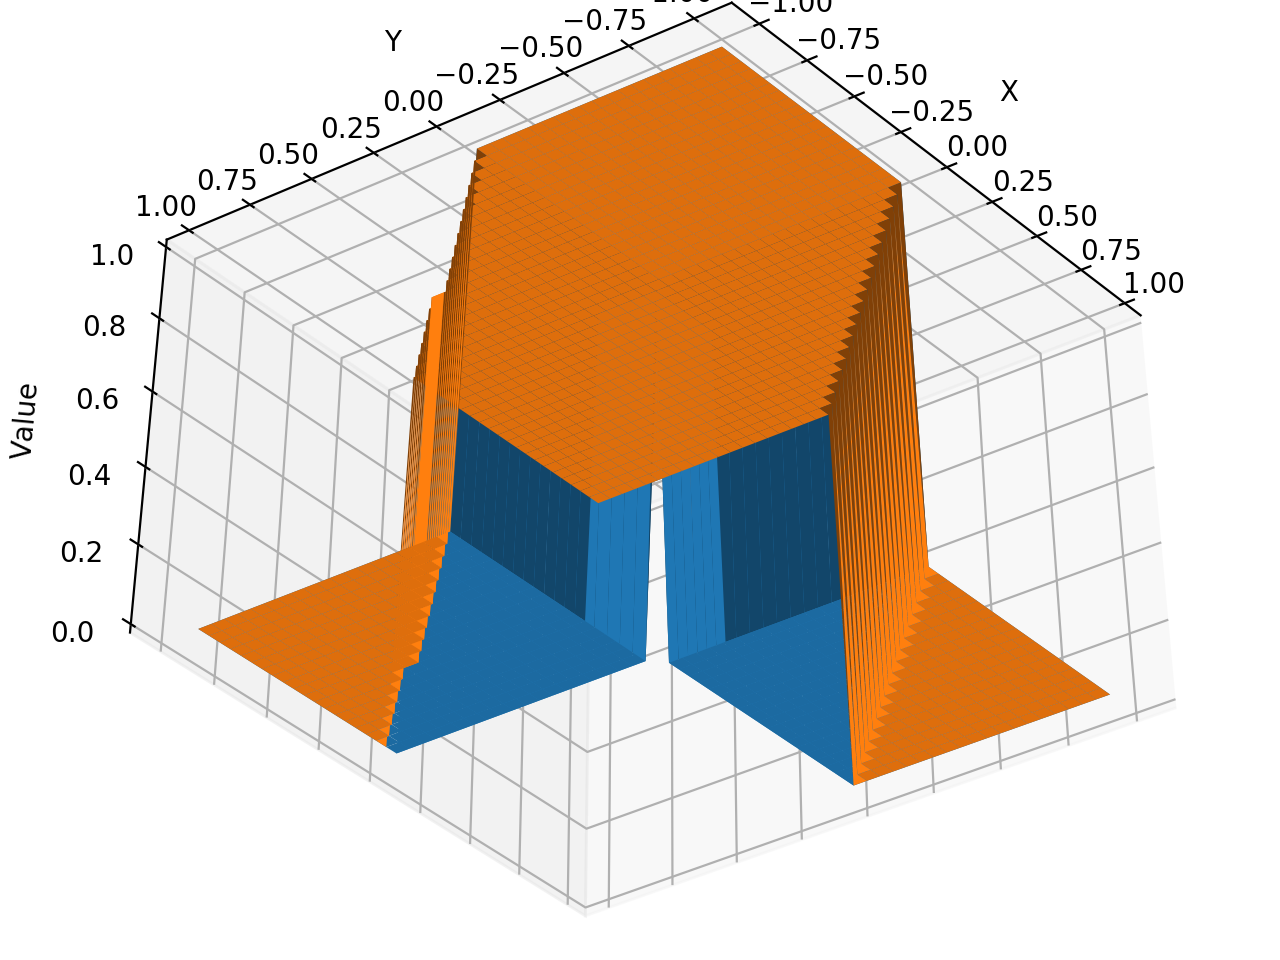

In [42]:
from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization! 
fig = plt.figure()
ax = ax = Axes3D(fig)

x = y = np.arange(-1.0, 1.0, 0.05)
X, Y = np.meshgrid(x, y)
z1s = np.array([original_fct(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z1 = z1s.reshape(X.shape)
z2s = np.array([approximate_fct(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z2 = z2s.reshape(X.shape)

ax.plot_surface(X, Y, Z1)
ax.plot_surface(X, Y, Z2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Value')

plt.show()